Constructing a realistic model.

In [372]:
# Convenience
import sys
sys.path.append('..')
import numpy as np
from tqdm.notebook import tqdm
import astropy.units as u
import pickle

%load_ext autoreload
%autoreload 2

# Math
from scipy.stats import shapiro
pi = np.pi
uni = np.random.uniform

# Plotting
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook
from plot_params import params
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["text.usetex"] = False

import logging
logging.getLogger().setLevel(logging.CRITICAL)

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from einops import rearrange

from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

from models.networks import build_mlp, build_maf
from models.sets import DeepSetLSTM, SetTransformerLSTM
from models.spatio_temporal import SpatioTemporalLSTM

from sklearn.metrics import roc_curve, auc

# Greg's Model
import lenstools as lt
from lenstools import nrm

# Sid's Model
from units import *
from astrosim import AstrometricSim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# histogram

def get_hist(data, bins=100, ran=None, xlabel='', title='', alpha=1):
    if ran is None:
        a,b = np.histogram(data, bins=bins, density=True)
    else:
        a,b = np.histogram(data, bins, ran, density=True)
        
    x = (b[1:] + b[:-1])/2
    b_width = np.diff(b)[0]
    plt.bar(x, a, b_width, alpha=alpha)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title(title, fontsize=20)

# Networks

In [3]:
class MultiBlipClassifier(pl.LightningModule):

    def __init__(self, dim_summary=96):
        """ Lightning module
        """
        super().__init__()
        self.deepset = DeepSetLSTM()
        self.spatio_temporal = SpatioTemporalLSTM(dim_hidden=dim_summary)
        self.mlp_y_hat = build_mlp(input_dim=int(2 * dim_summary),
                                   hidden_dim=int(2 * dim_summary),
                                   output_dim=1, layers=4)
#         self.deepset = SetTransformerLSTM(num_outputs=1, dim_output=1)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y = batch
#         y_hat = self.deepset(x)[:, 0]
        out = self.spatio_temporal(x)
        y_hat = self.mlp_y_hat(out)[:, 0]
        # GR: Binary cross-entropy loss function, essentially \sum_{two classes} x log y
        #    With logits means applying sigmoid before applying loss function
        #    You know something wrong when the loss is log(2) = .693

        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.spatio_temporal(x)
        y_hat = self.mlp_y_hat(out)[:, 0]
#         y_hat = self.deepset(x)[:, 0]
        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('val_loss', loss)
        return loss

# Parameters

In [520]:
Gaia_flag = True

# Gaia properties
if Gaia_flag:
    n_dens = 4.6e9 # objects per radian^2, 1804.01991 Table 1
    std_error = 100 / lt.rad_to_muas  # measurement error, 1609.04153 section 6.5 2nd to last paragraph

# Observation properties
N_train = int(16)  # training set size
N_temporal = 10  # number of temporal observations
N_obj = 20  # number of objects we want to see in an image
parallax = False  # include parallax of observer
dt = 1.  # yrs

# lens properties
kind = 'point'  # type of lens
M_lens = 1e3  # mass of lenses
R_lens = None

D_lens_max = 0.1
v_scale = lt.v_esc/5

rho_DM = .008 *1e9  # local mass density of DM, https://arxiv.org/abs/1205.4033, M_sol/kpc**3

# Disk properties
R_disk = 3.
D_disk = 8.

In [521]:
# !!! Is there an optimal N_obj?
# If 2, p(multiblip) small.
# If 20, p(multiblip) bigger, but some tradeoff (complicated network, fewer patches in the sky...)

# !!! How close can I assume lenses are?

In [522]:
# Derived

A_angle = N_obj/n_dens  # angular area required to see n_obj objects
l_angle = np.sqrt(A_angle)  # Side length of square image

n_lens = rho_DM/M_lens  # number density of DM

theta_disk_max = np.arcsin(R_disk/D_disk)

In [523]:
# probability of being x away, but in frame: ~x^2 dx => F(x) = (x/R)^3
# where R is the maximum distance away.
# To sample, set x = R U^(1/3), where U is sampled uniformly

In [524]:
def uniform_frame_angles(D):
    """place lenses uniformly in frame""" 
    
    angles = np.random.uniform(-l_angle, l_angle, (len(D),2)) + [pi/2,0]  # theta, phi
    
    x = D * np.sin(angles[:,0]) * np.cos(angles[:,1])
    y = D * np.sin(angles[:,0]) * np.sin(angles[:,1])
    z = D * np.cos(angles[:,0])

    return np.transpose([x,y,z])

In [525]:
# !!! Should I allow lenses to come from outside of a frame into it?

# y_lens = np.random.choice([0,1], size=N_train)
y_lens = np.ones(N_train)

# place lenses uniformly in the pyramid starting at the observer
# and ending at D_lens_max
D_lens = D_lens_max * uni(0,1,N_train)**(1/3)

x = uniform_frame_angles(D_lens)
v = np.random.normal(scale=v_scale, size=(N_train, 3))
lenses = lt.Lenses(
    np.repeat(x, N_obj, axis=0), # repeat so that every source has an associated lens
    np.repeat(v, N_obj, axis=0), 
    kind, 
    M_lens * np.repeat(y_lens, N_obj, axis=0), 
    R_lens
)

In [526]:
# model the disk as a perfect disk.
# Randomly view it, i.e. draw a ray through it from the observer
# and randomly place sources on it along the ray
theta_view = uni(-theta_disk_max, theta_disk_max, N_train)
beta_view = np.arcsin(D_disk*np.sin(theta_view)/R_disk)
alpha_view = beta_view - theta_view + pi
D_view_min = np.abs(R_disk * np.sin(alpha_view)/np.sin(theta_view))
D_view_max = D_view_min + 2 * np.sqrt(R_disk**2 - (D_disk * np.sin(theta_view))**2)

D_src = []
for i in range(N_obj):
    D_src.append(uni(D_view_min, D_view_max))
    
D_src = np.transpose(D_src).flatten()  # flatten frame-star dimensions

x = uniform_frame_angles(D_src)
v = np.random.normal(scale=v_scale, size=(N_train*N_obj, 3))
sources = lt.Sources(x, v)

# min(D_view_min), max(D_view_max)  # should range in D_disk +/- R_disk

In [595]:
%autoreload

O = lt.Observer(parallax=parallax)
data = [pi/2,0] - O.observe(sources, lenses, N=N_temporal, dt=dt)*[1,-1]
data = data.reshape(N_train, N_obj, N_temporal, 2)

# # Add error
# data_err = np.random.normal(loc=0, scale=std_error, size=(data.shape))
# data += data_err

x = torch.Tensor(data)
y = torch.Tensor(y_lens)

2687.7692065559645 [4.14673162e-10 1.97755134e-10 3.20527683e-10 4.01994403e-10
 2.65585398e-10 2.14265866e-10 3.54217110e-10 1.66127146e-10
 3.42509928e-10 3.90986203e-10 2.09499109e-10 2.19839511e-10
 4.31805094e-10 2.83917436e-10 3.60572653e-10 2.94752252e-10
 2.97823606e-10 2.06619365e-10 3.06287017e-10 4.55301893e-09]
2687.7692065559645 [4.14673162e-10 1.97755134e-10 3.20527683e-10 4.01994403e-10
 2.65585398e-10 2.14265866e-10 3.54217110e-10 1.66127146e-10
 3.42509928e-10 3.90986203e-10 2.09499109e-10 2.19839511e-10
 4.31805094e-10 2.83917436e-10 3.60572653e-10 2.94752252e-10
 2.97823606e-10 2.06619365e-10 3.06287017e-10 4.55301893e-09]
1270.34968372634 [4.29388445e-10 2.03713824e-10 3.27793427e-10 4.16858719e-10
 2.65017807e-10 2.22076247e-10 3.61249181e-10 1.69867040e-10
 3.52550372e-10 4.05075115e-10 2.13891608e-10 2.26103826e-10
 4.38831240e-10 2.96299522e-10 3.64069746e-10 3.03052085e-10
 3.05392472e-10 2.10194099e-10 3.05245663e-10 3.47396271e-09]
860.5775972677654 [4.449576

# Viz

  0%|          | 0/16 [00:00<?, ?it/s]

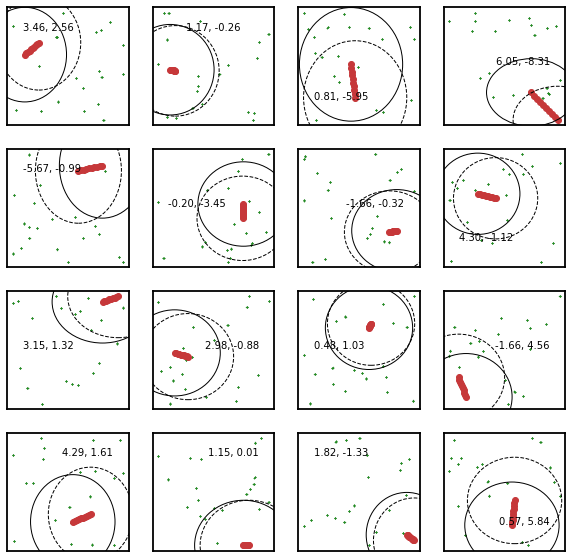

In [753]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))

gs = GridSpec(4, 4)

lens_pos = [pi/2, 0] - O.observe(lenses, N=N_temporal, dt=dt)[::N_obj]*[1,-1]

ind = 0
offset = (ind-1)*16
for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    for j, x_i in enumerate(x[offset + i]):
        ax.scatter(x_i[:,0], x_i[:,1], color='forestgreen', s=0.2)
    
    # 17 and 16 are in circle
    if y[offset + i]:
#         print(lt.nrm(lenses.x[::N_obj][offset+i]), lt.nrm(lenses.v[::N_obj][offset+i]))
        label = "{:.2f}, {:.2f}".format(*(lens_pos[offset + i][-1]-lens_pos[offset + i][0])/lt.arcsec)
        ax.scatter(lens_pos[offset + i][:,0], lens_pos[offset + i][:,1])
        
        area_of_influence1 = plt.Circle((lens_pos[offset + i][0,0],
                                        lens_pos[offset + i][0,1]), 
                                       4*lt.G_N*M_lens/(D_disk * std_error * lt.c**2), fill = False)
        
        area_of_influence2 = plt.Circle((lens_pos[offset + i][-1,0],
                                        lens_pos[offset + i][-1,1]), 
                                       4*lt.G_N*M_lens/(D_disk * std_error * lt.c**2), fill = False, linestyle='--')
        
        ax.add_artist(area_of_influence1)
        ax.add_artist(area_of_influence2)
        
        ax.legend(title=label)
        
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

# Time-series deep set model

# Classification

In [119]:
greg_sim = False

if greg_sim:
    xx, yy = x2, y2
else:
    xx,yy = x,y


val_fraction = 0.1
n_samples_val = int(val_fraction * len(xx))

dataset = TensorDataset(xx, yy)

dataset_train, dataset_val = random_split(dataset, [len(xx) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

model = MultiBlipClassifier()
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=4, gpus=0, gradient_clip_val=1.,
                     callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name            | Type               | Params
-------------------------------------------------------
0 | deepset         | DeepSetLSTM        | 1.1 M 
1 | spatio_temporal | SpatioTemporalLSTM | 70.8 K
2 | mlp_y_hat       | Sequential         | 5.3 K 
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.872     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate classification performance

In [120]:
model.eval()

y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch = batch
    y_hat.append(torch.sigmoid(model.deepset(x_batch)).to('cpu').detach().numpy())
    y_val.append(y_batch)
    
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

  0%|          | 0/2 [00:00<?, ?it/s]

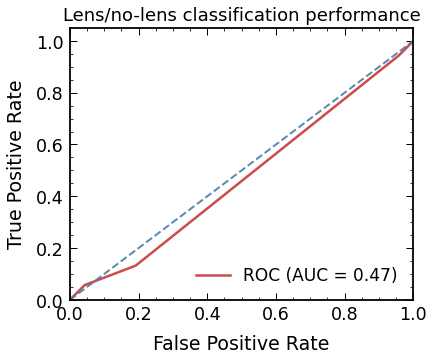

In [121]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

# Inference

In [127]:
y_lens_prop_mean = y_lens_prop.mean(-2)
y_lens_prop_std = y_lens_prop.std(-2)

y_lens_prop = (y_lens_prop - y_lens_prop_mean) / y_lens_prop_std

NameError: name 'y_lens_prop' is not defined

In [224]:
data.shape

(20000, 10, 2)

In [365]:
y_lens_prop = torch.Tensor(y_lens_prop)

In [368]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y, y_lens_prop)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

In [20]:
model.eval()

MultiBlipClassifier(
  (deepset): DeepSetLSTM(
    (phi): LSTM(2, 64, num_layers=8, batch_first=True, bidirectional=True)
    (phi_mlp): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): ReLU()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): ReLU()
      (10): Linear(in_features=256, out_features=128, bias=True)
    )
    (rho): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(i

In [369]:
from models.sets import DeepSetLSTM, SetTransformerLSTM

In [370]:
class MultiBlipInference(pl.LightningModule):

    def __init__(self, output_dim=128):
        """ Lightning module
        """
        super().__init__()
#         self.deepset = DeepSetLSTM(hidden_dim=64, output_dim=128)
        self.deepset = SetTransformerLSTM(num_outputs=1, dim_output=128)
        self.flow = build_maf(dim=2, num_transforms=8, context_features=64, hidden_features=128)
        self.mlp_y_hat = build_mlp(input_dim=64, hidden_dim=128, output_dim=1, layers=3)
        self.mlp_post = build_mlp(input_dim=64, hidden_dim=128, output_dim=64, layers=3)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('val_loss', loss)
        return loss


In [29]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

In [371]:
model = MultiBlipInference()

In [372]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=25, gpus=1, gradient_clip_val=1., callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type               | Params
-------------------------------------------------
0 | deepset   | SetTransformerLSTM | 682 K 
1 | flow      | Flow               | 342 K 
2 | mlp_y_hat | Sequential         | 58.0 K
3 | mlp_post  | Sequential         | 66.1 K
-------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.594     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate

In [373]:
model.to('cuda');
model.eval();

In [374]:
y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch, y_lens_batch = batch
    out_batch = model.deepset(x_batch.to('cuda'))
    y_hat.append(torch.sigmoid(model.mlp_y_hat(torch.chunk(out_batch, 2, -1)[-1])).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/47 [00:00<?, ?it/s]

In [375]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [376]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

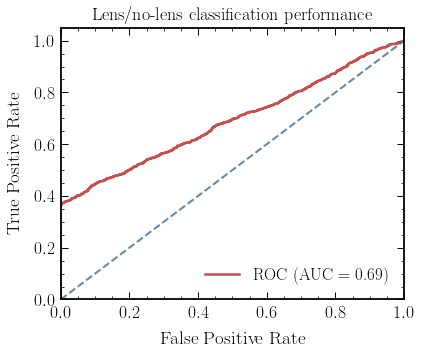

In [377]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

In [381]:
def destandardize(samples):
    return samples #* y_lens_prop_std + y_lens_prop_mean

In [382]:
# import seaborn as sns

# fig = plt.figure(figsize=(12, 12))

# gs = GridSpec(4, 4)

# for ii, i in tqdm(enumerate(range(16, 16 + 16))):
    
#     ax = fig.add_subplot(gs[ii])
    
#     idx = torch.where(y == 1)[0][i].numpy()
#     context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
#     samples, log_prob = model.flow.sample_and_log_prob(num_samples=5000, context=context)

#     samps = np.nan_to_num(samples.cpu().detach().numpy()[0]).T
    
#     sns.kdeplot(x=samps[0], y=samps[1], fill=True, levels=50, cmap=sns.color_palette("Blues", as_cmap=True), thresh=0.5, alpha=0.65, ax=ax)
    
#     ax.axvline(y_lens_prop[idx].numpy()[0])
#     ax.axhline(y_lens_prop[idx].numpy()[1])
    

In [20]:
# import corner

# for i in range(20, 30):

#     idx = torch.where(y == 1)[0][i].numpy()
#     context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
#     samples, log_prob = model.flow.sample_and_log_prob(num_samples=50000, context=context)
#     corner.corner(destandardize(samples.cpu().detach().numpy()[0]) , truths=destandardize(y_lens_prop[idx].numpy()));
    

# Spatial aggregation then temporal processing

In [20]:
import sys
sys.path.append("../")

In [21]:
from models.networks import build_mlp, build_maf
from models.spatio_temporal import SpatioTemporalLSTM

In [22]:
x.shape

torch.Size([20000, 20, 10, 2])

In [23]:
x = (x - x.mean()) / x.std()

In [24]:
stl = SpatioTemporalLSTM(dim_hidden=64)

In [25]:
stl(x[:8])  # takes in a batch of 8, spits out features

tensor([[-0.0685,  0.0871,  0.0119,  ..., -0.0603,  0.0038, -0.1108],
        [-0.0681,  0.0872,  0.0121,  ..., -0.0603,  0.0038, -0.1108],
        [-0.0683,  0.0872,  0.0121,  ..., -0.0603,  0.0038, -0.1108],
        ...,
        [-0.0692,  0.0878,  0.0116,  ..., -0.0603,  0.0037, -0.1108],
        [-0.0679,  0.0873,  0.0124,  ..., -0.0603,  0.0038, -0.1108],
        [-0.0691,  0.0872,  0.0113,  ..., -0.0603,  0.0037, -0.1108]],
       grad_fn=<UnsafeViewBackward0>)

In [26]:
y_lens_prop_mean = y_lens_prop.mean(-2)
y_lens_prop_std = y_lens_prop.std(-2)

y_lens_prop = (y_lens_prop - y_lens_prop_mean) / y_lens_prop_std

In [27]:
y_lens_prop = torch.Tensor(y_lens_prop)

In [28]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y, y_lens_prop)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=128, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, num_workers=8, pin_memory=True, shuffle=False)

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
class MultiBlipInference(pl.LightningModule):

    
    def __init__(self, dim_summary=96):  # dimension of feature vector output
        """ Lightning module
        """
        super().__init__()

        self.spatio_temporal = SpatioTemporalLSTM(dim_hidden=dim_summary)
        self.flow = build_maf(dim=2, num_transforms=8, context_features=dim_summary, hidden_features=128)
        self.mlp_y_hat = build_mlp(input_dim=dim_summary, hidden_dim=int(2 * dim_summary),
                                   output_dim=1, layers=4)
        self.mlp_post = build_mlp(input_dim=dim_summary, hidden_dim=int(2 * dim_summary), output_dim=dim_summary, layers=4)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.spatio_temporal(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.spatio_temporal(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('val_loss', loss)
        return loss


In [30]:
model = MultiBlipInference()

In [31]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=50, gpus=1, gradient_clip_val=0.5, callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Set SLURM handle signals.

  | Name            | Type               | Params
-------------------------------------------------------
0 | spatio_temporal | SpatioTemporalLSTM | 1.9 M 
1 | flow            | Flow               | 841 K 
2 | mlp_y_hat       | Sequential         | 167 K 
3 | mlp_post        | Sequential         | 185 K 
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.402    Total estimated model params size (MB)
/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /net/rcstorenfs02/ifs/rc_labs/dvorkin_lab/smsharma/Astrometric_TSeries_ML/notebooks/lightning_logs/version_3902984/checkpoints exists and is not empty.
  rank_zero_warn(f"Ch

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Evaluate

In [32]:
model.to('cuda');
model.eval();

In [33]:
y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch, y_lens_batch = batch
    out_batch = model.spatio_temporal(x_batch.to('cuda'))
    y_hat.append(torch.sigmoid(model.mlp_y_hat(torch.chunk(out_batch, 2, -1)[-1])).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/16 [00:00<?, ?it/s]

In [34]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

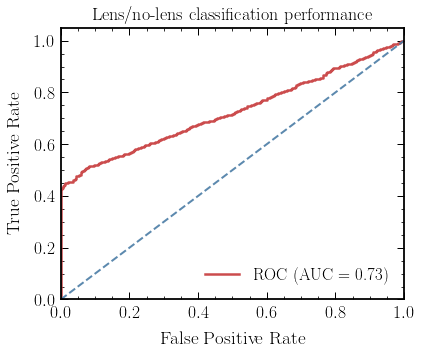

In [36]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

In [37]:
def destandardize(samples):
    return samples * y_lens_prop_std + y_lens_prop_mean

In [38]:
import corner

labels = [r'$\log_{10} M\,[\mathrm{M}_\odot]$',r'$\log_{10} (R\,[\mathrm{pc}])$']

  0%|          | 0/40 [00:00<?, ?it/s]

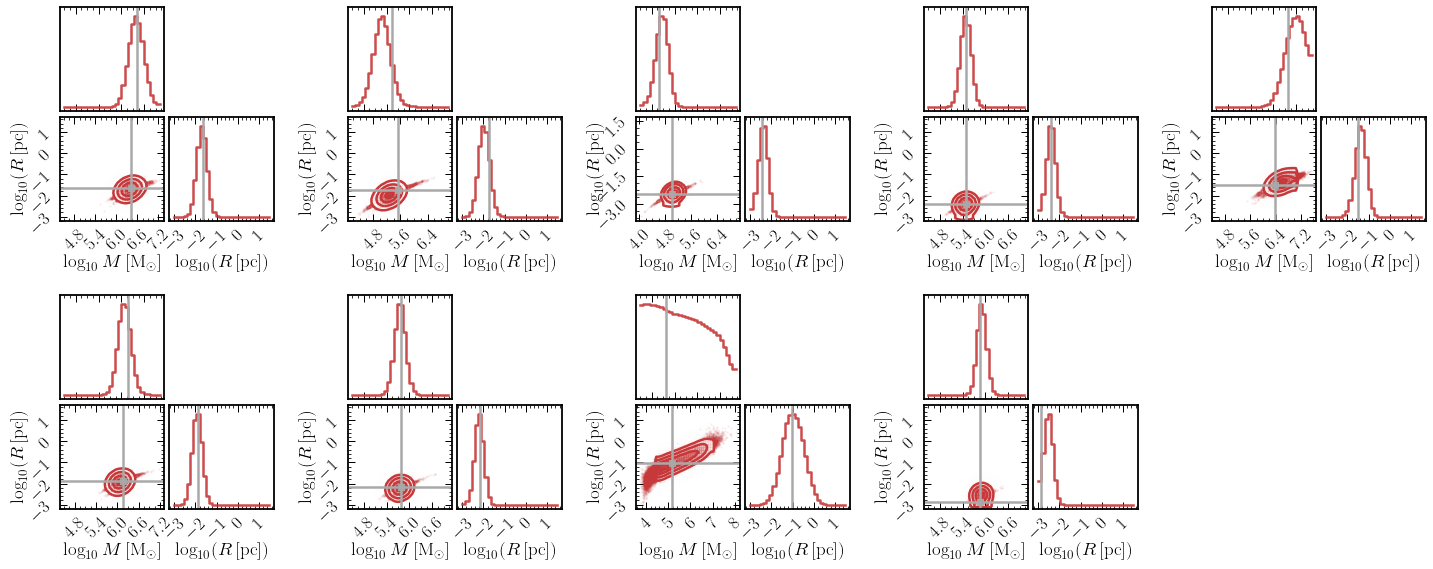

In [43]:
n_plots = 5
fig = plt.figure(figsize=(20, 8))
subfigs = fig.subfigures(2, n_plots)

n_fig = 0
for i in (range(0, 40)):

    idx = torch.where(y_batch == 1)[0][i].numpy()
    feats = torch.chunk(model.spatio_temporal(x_batch[idx].unsqueeze(0).to('cuda')), 2, -1)
    context = model.mlp_post(feats[0])
    y_hat = model.mlp_y_hat(feats[1])[:, 0]
    if y_hat.sigmoid() > 0.7:
        samples, log_prob = model.flow.sample_and_log_prob(num_samples=50000, context=context)
        corner.corner(destandardize(samples.cpu().detach().numpy()[0]), fig=subfigs[n_fig // 5, n_fig % 5], truths=destandardize(y_lens_batch[idx].numpy()), range=[[4.5,7],[-3,1.5]], plot_contours=True, bins=30, smooth=2, smooth1d=1.3, labels=labels, color=cols_default[0], truth_color='darkgrey');
        n_fig += 1
    if n_fig == 2 * n_plots:
        break

# Estimating Parameters

In [75]:
def estimate(M_lens, R_nearby=1):
    Omega_disk = 0.2  # rad^2, disk size
    R_disk = 8  # kpc, disk radius
    M_mw = 1e12  # M_sol, Milky Way mass
    R_mw = 300  # kpc, https://arxiv.org/abs/2002.09497
    
    
    # lens number density
    rho_lens = np.array([M_mw / (4/3 * np.pi * R_mw**3), .008e9])
    n_lens = rho_lens/M_lens
    
    # Total number of lenses in our images 
    SA = 4 * np.pi * R_disk**2
    A_base = Omega_disk * SA  # assume a square base
    V_obs = 1/3 * A_base * R_disk
    print('# of lenses in all images:', n_lens * V_obs)
    
    
#     ns = [n_lens]
#     rho_lens = .008e9
#     ns.append(rho_lens/M_lens)
    SA = 4 * np.pi * R_nearby**2
    A_base = Omega_disk * SA
    V_obs = 1/3 * A_base * R_nearby
    print('# of lenses in all images that are '+str(R_nearby)+' kpc away:', n_lens * V_obs)
    
    print('deflections will be greater than (mu_as)', 4 * lt.G_N * M_lens / (R_disk*l_angle/2 * lt.c**2) * lt.rad_to_muas)
    
    
    l_s = np.sqrt(1/n_dens)  # rad, angular separation begtween sources
    v = 100e-9  # kpc/yr, velocity of lenses or sources
    
    print('typical distance between sources (as):', l_s / lt.arcsec)
    print('typical velocity of sources (mas/yr):', v/R_disk / lt.arcsec * 1e3)
    print('lenses better be '+str(l_s*R_disk/v)+' times closer to travel between two sources')
    
estimate(1e3, .1)

# of lenses in all images: [   3792.59259259 3431456.93576101]
# of lenses in all images that are 0.1 kpc away: [0.00740741 6.70206433]
deflections will be greater than (mu_as) 128.7656264234675
typical distance between sources (as): 3.5355339059327378
typical velocity of sources (mas/yr): 2.578310078088704
lenses better be 1371.2601660982612 times closer to travel between two sources
